In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import helper as hp

In [2]:
#get data
# images are divided up into vehicles and non-vehicles

cars   = glob.glob('training_data/vehicles/**/*.png')
notcars= glob.glob('training_data/non-vehicles/**/*.png')

#cars   = glob.glob('training_small_set/vehicles_smallset/**/*.jpeg')
#notcars= glob.glob('training_small_set/non-vehicles_smallset/**/*.jpeg')

print(len(cars), len(notcars))

8792 8968


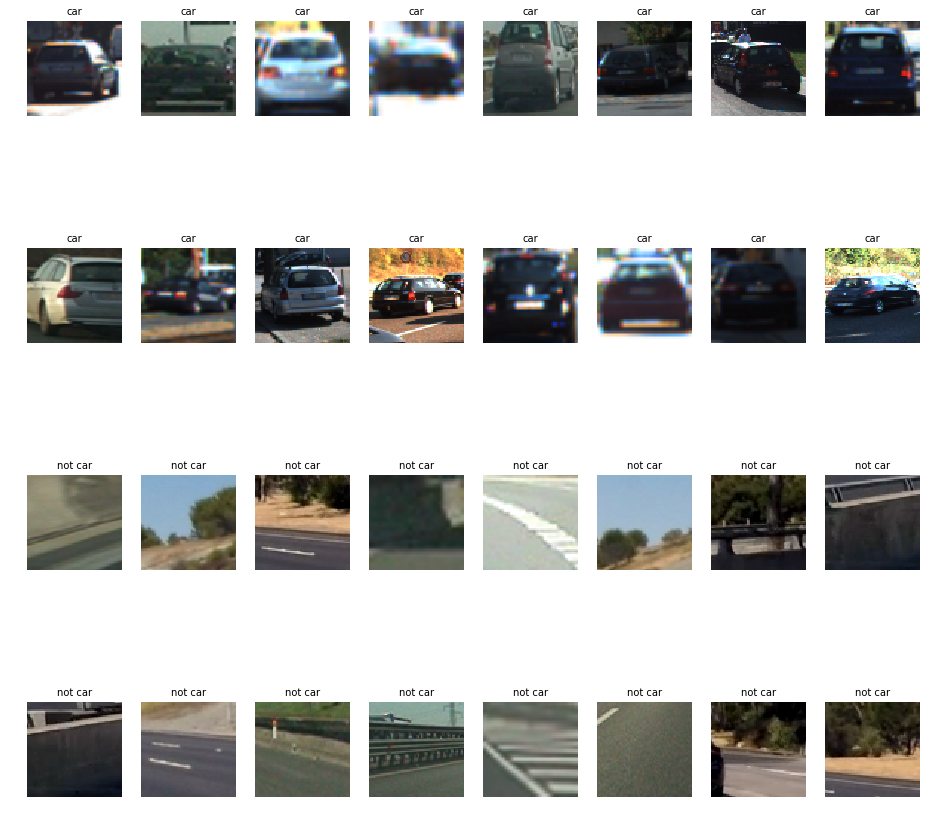

In [3]:
#visualize the data
fig, axs = plt.subplots(4,8, figsize=(16, 16))

axs = axs.ravel()

for i in np.arange(16):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
    
for i in np.arange(16,32):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)

In [4]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=True,tnsfrm_sqrt=True):
                         
    # TODO: Complete the function body and returns
    return hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec,
                          transform_sqrt=tnsfrm_sqrt)#,block_norm="L2-Hys")

C:\Users\anupam\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


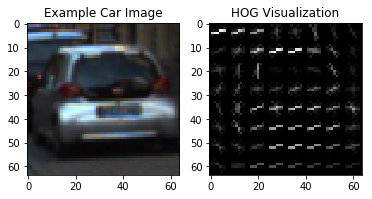

In [5]:
# Generate a random index to look at a car image
index = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[index])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_img = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False,tnsfrm_sqrt=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

In [6]:
#taken partially from class
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,tnsfrm_sqrt1=False,spatial_sz=(32,32),hst_bins=32):
    # Create a list to append feature vectors to
    features = []
    f=[]
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True,tnsfrm_sqrt=tnsfrm_sqrt1))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True,tnsfrm_sqrt=tnsfrm_sqrt1)
            
        #Get color features
        spatial_features = hp.bin_spatial(feature_image, size=spatial_size)
        hist_features = hp.color_hist(feature_image, nbins=hist_bins)
        
        features.append(np.concatenate((spatial_features,hist_features,hog_features)))

    return features

In [7]:
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
colorspace = 'YUV' 
orient = 11
pix_per_cell =8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
transform_sqrt=False   #True or False
spatial_size=(16,16)
hist_bins=8

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,tnsfrm_sqrt1=transform_sqrt,spatial_sz=spatial_size,hst_bins=hist_bins)

notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,tnsfrm_sqrt1=transform_sqrt,spatial_sz=spatial_size,hst_bins=hist_bins)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

C:\Users\anupam\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


93.52 Seconds to extract HOG features...


In [8]:
#display length of a single feature vector
print(len(notcar_features[0]))

7260


In [15]:
#cod influenced by classroom section
#train a classifier  
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7260
5.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
For these 10 labels:  [0. 1. 0. 0. 1. 1. 0. 1. 0. 0.]
0.0 Seconds to predict 10 labels with SVC


In [ ]:
#save the classifier if it returns a better result
import pickle

pickle_out = open("classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue","wb")
pickle.dump(svc, pickle_out)
pickle_out.close()

pickle_out = open("classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue_scaler","wb")
pickle.dump(X_scaler, pickle_out)
pickle_out.close()
print(len(X_train) + len(X_test))

In [16]:
# code influenced by classroom
# efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = hp.bin_spatial(subimg, size=spatial_size)
            hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

(16, 16) 11
test_images\test1.jpg


C:\Users\anupam\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


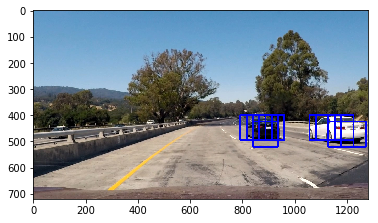

test_images\test2.jpg


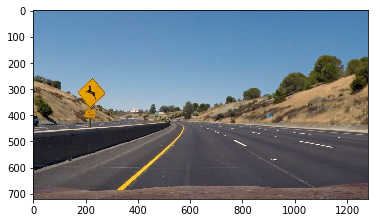

test_images\test3.jpg


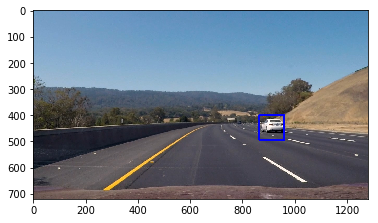

test_images\test4.jpg


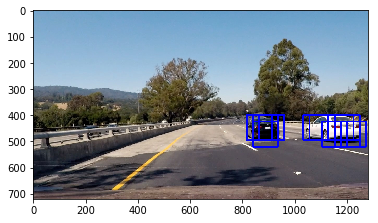

test_images\test5.jpg


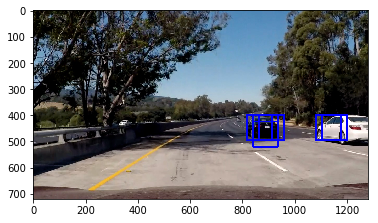

test_images\test6.jpg


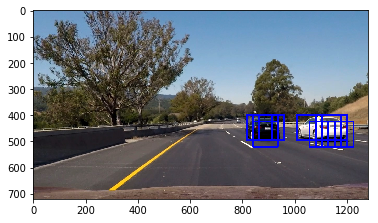

In [18]:
#plot find car
import pickle
ystart = 400
ystop = 656
scale = 1.5
#svc=pickle.load(open('classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue', 'rb'))
#X_scaler=pickle.load(open('classifiers/YUV_11orient_allFeatures_16spatialand8bins_8cells_transform_sqrtTrue_scaler', 'rb'))
orient=11
pix_per_cell=8
cell_per_block=2
spatial_size=(16,16)
hist_bins=8
color_space='RGB2YUV' #'RGB2HLS'  #'RGB2YCrCb'
print(spatial_size,orient)
test_images=glob.glob('test_images/*.jpg')

#plotting images for 1 scale
boxes=[]
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    #print(boxes[0][0])
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

test_images\test1.jpg


C:\Users\anupam\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


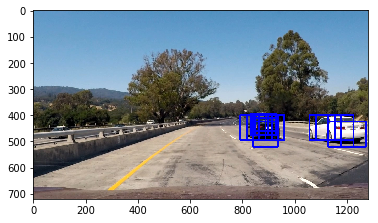

test_images\test2.jpg


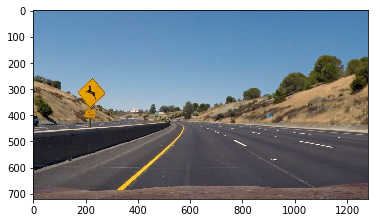

test_images\test3.jpg


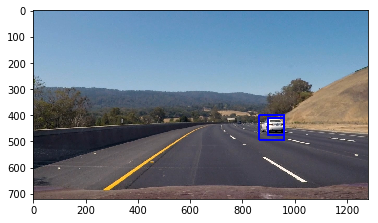

test_images\test4.jpg


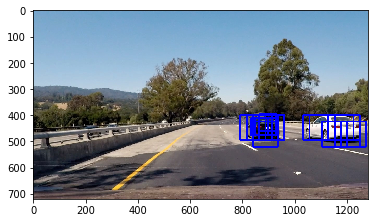

test_images\test5.jpg


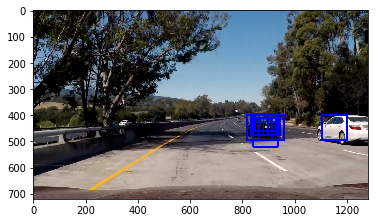

test_images\test6.jpg


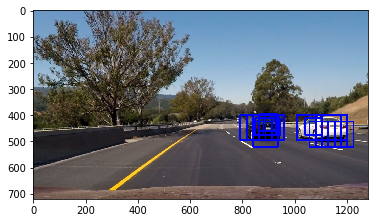

In [19]:
#plotting images on multiple scales and different region of interests
ystarts=[380,400,472,496]#,504]
ystops =[476,560,560,656]#,672]

scales=[1.0,1.5,2.0,2.5]#,3.0]
#print(len(ystart),len(ystop),len(scales))

i=0
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=[]
    for i in range(len(scales)):
        boxes.append(find_cars(test_img, ystarts[i], ystops[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [21]:
#add heat_maps
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

test_images\test1.jpg


C:\Users\anupam\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


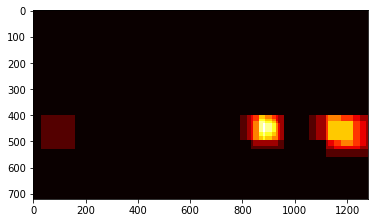

test_images\test2.jpg


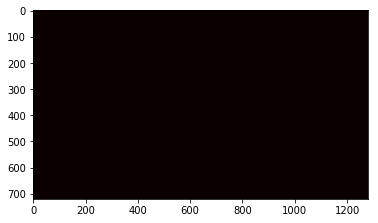

test_images\test3.jpg


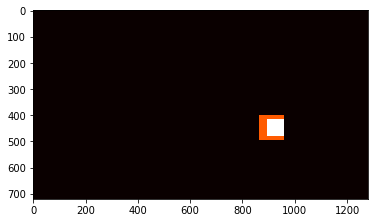

test_images\test4.jpg


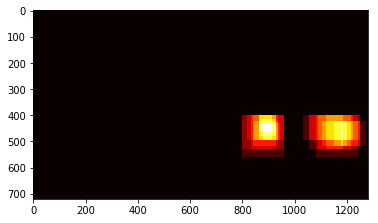

test_images\test5.jpg


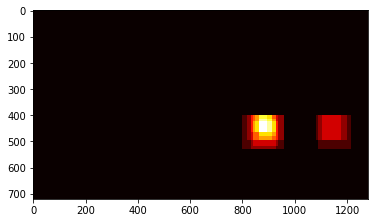

test_images\test6.jpg


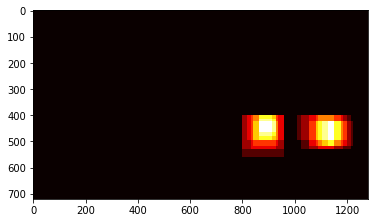

In [22]:
for fname in test_images:
    print(fname)
    test_img=mpimg.imread(fname)
    #plt.subplot(6,1,i)
    boxes=[]
    for i in range(len(scales)):
        boxes.append(find_cars(test_img, ystart, ystop, scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 

    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    #heatmap_img = apply_threshold(heatmap_img,2)
    plt.imshow(heatmap_img, cmap='hot')
    plt.show()

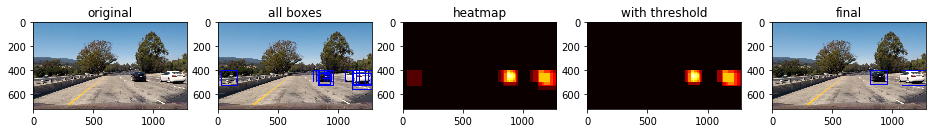

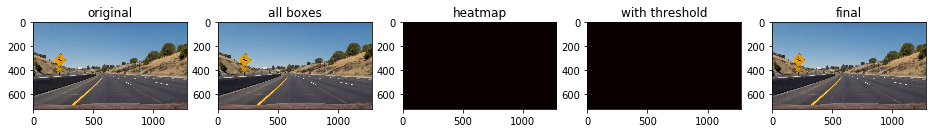

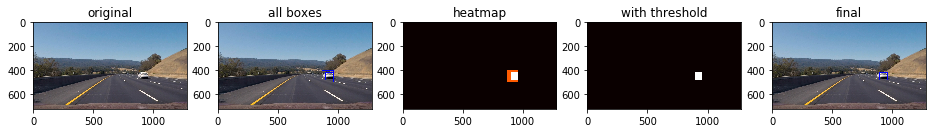

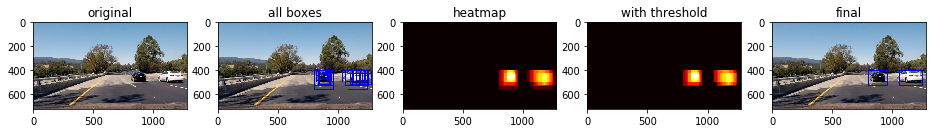

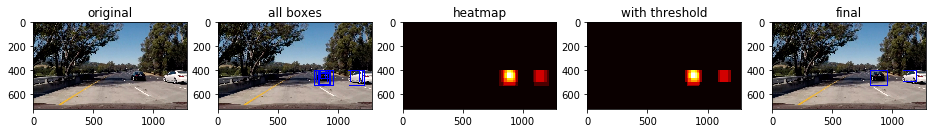

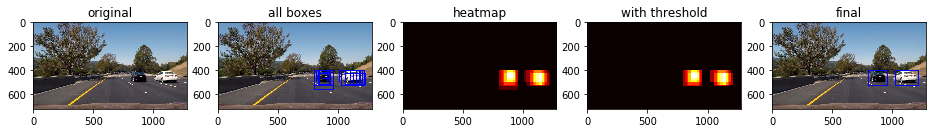

In [29]:
i=0
for fname in test_images:
    #print(fname)

    f = plt.figure(figsize=(16,16))
    test_img=mpimg.imread(fname)
    
    plt.subplot(1,5,1)
    plt.title("original")
    plt.imshow(test_img)
    
    boxes=[]
    for i in range(len(scales)):
        boxes.append(find_cars(test_img, ystart, ystop, scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))  
    boxes = [item for sublist in boxes for item in sublist] 
    plt.subplot(1,5,2)
    plt.title("all boxes")
    plt.imshow(draw_boxes(test_img,boxes))

    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
    plt.subplot(1,5,3)
    plt.title("heatmap")
    plt.imshow(heatmap_img,cmap='hot')
    
    
    heatmap_img = apply_threshold(heatmap_img,1)
    heatmap = np.clip(heatmap_img, 0, 255)
    plt.subplot(1,5,4)
    plt.title("with threshold")
    plt.imshow(heatmap_img,cmap='hot')
    
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    plt.subplot(1,5,5)
    plt.title("final")
    plt.imshow(draw_img)
    
    f.savefig('output_images/'+fname.split('\\')[1])
    plt.show()

In [27]:
#print(scales,ystarts)
from collections import deque

heat_history=deque(maxlen=8)

def process_frame(image):
    boxes=[]
    for i in range(len(scales)):
        boxes.append(find_cars(image, ystarts[i], ystops[i], scales[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
    heat_history.append(heatmap_img)
    heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,5)
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [28]:
from moviepy.editor import VideoFileClip

output_location = 'test_output_video/yuv_11_8_debug_full_without_ystart.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("project_video.mp4")#.subclip(40,43)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

anupam
[MoviePy] >>>> Building video test_output_video/yuv_11_8_debug_full_without_ystart.mp4
[MoviePy] Writing video test_output_video/yuv_11_8_debug_full_without_ystart.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:03<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output_video/yuv_11_8_debug_full_without_ystart.mp4 

